### Run basic `scanpy` QC and doublet detection with `scrublet` for **PBMC Tuberculosis** _Nathan et al 2021_

>> Based on the following scanpy tutorial: https://scanpy-tutorials.readthedocs.io/en/multiomics/cite-seq/pbmc5k.html#Reading
>> Only uses filtered data

- **Developed by**: Mairi McClean
- **Computational Health Centre - Helmholtz Munich**
- v221117

### Load required modules

##### Different due to type of data used (cite-seq)

In [1]:
import anndata
import logging
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sb
import scrublet as scr
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import rcParams

In [2]:
sc.settings.verbosity = 3
sc.logging.print_versions()
sc.set_figure_params(frameon=False, figsize=(4, 4))


-----
anndata     0.8.0
scanpy      1.9.1
-----
PIL                 9.2.0
appnope             0.1.3
asttokens           NA
backcall            0.2.0
beta_ufunc          NA
binom_ufunc         NA
cffi                1.15.1
colorama            0.4.6
cycler              0.10.0
cython_runtime      NA
dateutil            2.8.2
debugpy             1.6.3
decorator           5.1.1
entrypoints         0.4
executing           1.1.1
h5py                3.6.0
hypergeom_ufunc     NA
ipykernel           6.16.2
jedi                0.18.1
joblib              1.2.0
kiwisolver          1.4.4
llvmlite            0.39.1
matplotlib          3.6.1
mpl_toolkits        NA
natsort             8.2.0
nbinom_ufunc        NA
ncf_ufunc           NA
numba               0.56.3
numexpr             2.8.1
numpy               1.23.4
packaging           21.3
pandas              1.5.1
parso               0.8.3
pexpect             4.8.0
pickleshare         0.7.5
pkg_resources       NA
prompt_toolkit      3.0.31
psutil      

### Read datasets

In [34]:
# sc.read function changed to h5ad from h5 in tutorial (17.11.22)

# anndata.read function inserted: output the same (18.11.22)

adata = sc.read_h5ad('/Users/mairi.mcclean/github/data/tb_pbmc_datasets/Lung_TB_T_Cells_CITESEQ_RNA.h5ad')

In [4]:
# no variables present?

adata

AnnData object with n_obs × n_vars = 500089 × 33538
    obs: 'cell_id', 'nUMI', 'nGene', 'percent_mito', 'batch', 'TB_status', 'UMAP_1', 'UMAP_2', 'cluster_name', 'cluster_ids', 'donor'

In [5]:
# Only 1 column of variables? They appear to be gene names

adata.var

""
MIR1302-2HG
FAM138A
OR4F5
AL627309.1
AL627309.3
...
AC233755.2
AC233755.1
AC240274.1
AC213203.1


In [6]:
adata.obs

,cell_id,nUMI,nGene,percent_mito,batch,TB_status,UMAP_1,UMAP_2,cluster_name,cluster_ids,donor
0,AAACCCAAGGCCTAAG-1,6108,1557,0.055828,1,CASE,-2.743703,1.617194,CD4+ CD27+,C-2,TB3419057
1,AAACCCAAGGTTCTTG-1,7902,2149,0.083017,1,CASE,-4.237045,0.306832,CD4+ CCR4+ central,C-3,TB3419057
2,AAACCCAAGTGCAGGT-1,5033,1788,0.129744,1,CASE,-1.136187,-4.012949,CD4+ Treg,C-9,TB3419057
3,AAACCCACAAGAGTAT-1,6574,1747,0.066930,1,CASE,-1.015078,3.789505,CD4+ CD27+CD161+,C-4,TB3419057
4,AAACCCACACACGGTC-1,6471,1872,0.047442,1,CASE,0.658381,2.427080,CD4+ Th17/1,C-13,TB0610655
...,...,...,...,...,...,...,...,...,...,...,...
500084,TTTGTTGTCCGCCTAT-46,1945,833,0.183033,46,CASE,-2.568426,0.780417,CD4+ CD27+,C-2,TB9334348
500085,TTTGTTGTCCTGGGTG-46,4534,1537,0.051610,46,CONTROL,1.017550,-0.594416,CD4+ Th1,C-17,TB2792656
500086,TTTGTTGTCGATGGAG-46,3157,1013,0.081723,46,CASE,2.301589,0.623997,CD4+ Th17/1,C-16,TB7198118
500087,TTTGTTGTCGTTTACT-46,3675,1202,0.089252,46,CASE,0.572390,-1.264730,CD4+ Th1,C-17,TB9334348


In [ ]:
# Following cells were separated from 1 complete cell to avoid error

In [7]:
adata.var_names_make_unique()

In [8]:
adata.layers["counts"] = adata.X.copy()

In [10]:
adata.layers["counts"]

<500089x33538 sparse matrix of type '<class 'numpy.float32'>'
	with 737214512 stored elements in Compressed Sparse Row format>

In [45]:
adata

AnnData object with n_obs × n_vars = 500089 × 26199
    obs: 'cell_id', 'nUMI', 'nGene', 'percent_mito', 'batch', 'TB_status', 'UMAP_1', 'UMAP_2', 'cluster_name', 'cluster_ids', 'donor'
    var: 'n_counts'

In [37]:
adata.obs.TB_status

0            CASE
1            CASE
2            CASE
3            CASE
4            CASE
           ...   
500084       CASE
500085    CONTROL
500086       CASE
500087       CASE
500088    CONTROL
Name: TB_status, Length: 500089, dtype: category
Categories (2, object): ['CASE', 'CONTROL']

In [ ]:
# so we don't know specific disease status?

In [13]:
adata.var["n_counts"].value_counts()

1.0         1420
2.0          765
3.0          586
4.0          403
5.0          323
            ... 
12761.0        1
27015.0        1
146730.0       1
124901.0       1
6799.0         1
Name: n_counts, Length: 12743, dtype: int64

In [ ]:
# Output doen't appear to be the same as the tutorial; data in tutorial has no obs. We have no var. Same same but different?

In [15]:
# added to make sure that sample_object was valid object for following code

sample_object = adata.copy()
sample_object

AnnData object with n_obs × n_vars = 500089 × 26199
    obs: 'cell_id', 'nUMI', 'nGene', 'percent_mito', 'batch', 'TB_status', 'UMAP_1', 'UMAP_2', 'cluster_name', 'cluster_ids', 'donor'
    var: 'n_counts'
    layers: 'counts'

normalizing counts per cell
    finished (0:00:12)


/opt/homebrew/Caskroom/mambaforge/base/envs/scanpy_v1.9.1/lib/python3.10/site-packages/seaborn/categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


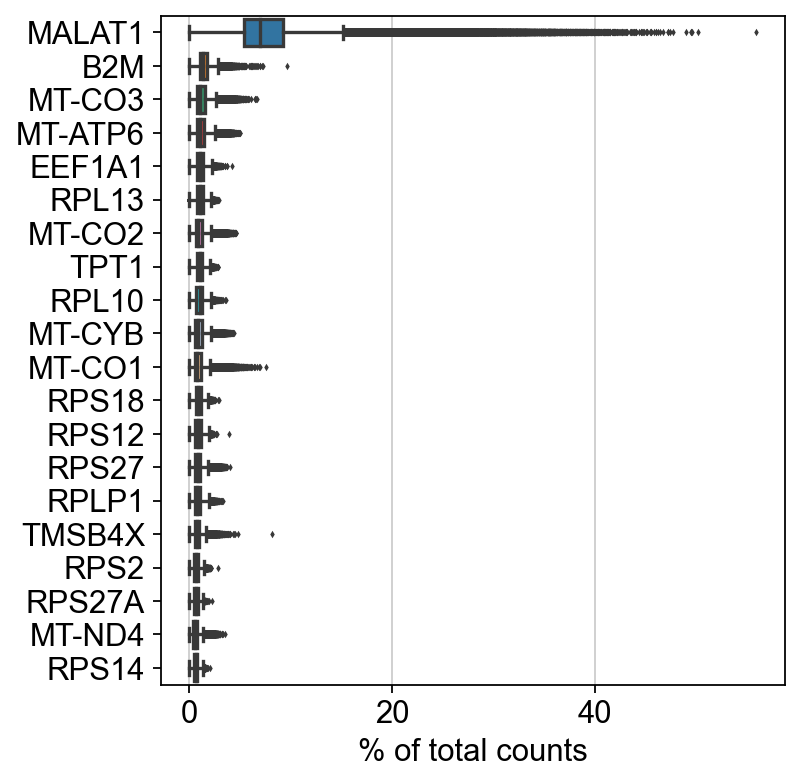

In [40]:
# Show the top 20 genes

sc.pl.highest_expr_genes(sample_object, n_top=20)


In [ ]:
# So there are already labelled mit genes?

### Compute QC stats

#### Filter mt-genes

In [ ]:
# Percentage mito genes has already been calculated, therefore only simple filtering required?
# Will remove ribosomal gene step for ease in first round of experiment

# Values we do have: percent mito, nUMI, n_genes

#### Filter cells with less than 200 genes and min cells



In [46]:
# ran experiment to see what would happen

sc.pp.filter_cells(sample_object, min_genes = 200)
sc.pp.filter_genes(sample_object, min_counts=3)

filtered out 2185 genes that are detected in less than 3 counts


In [47]:
print(sample_object.n_obs, sample_object.n_vars)

500089 24014


In [48]:
sample_object.shape

(500089, 24014)

In [18]:
sample_object.var

,n_counts
OR4F5,1.0
AL627309.1,856.0
AL627309.3,45.0
AL627309.4,4.0
AL669831.2,13.0
...,...
AL354822.1,3698.0
AC004556.1,32487.0
AC233755.2,3.0
AC233755.1,2.0


In [ ]:
# Removed following section ['Replace gene symbols'] as I don't think it's required?

### mt and ribo QC stats

In [20]:
sample_object.shape

(500089, 26199)

In [ ]:
# Is there a way to filter out a certian percentage of mito gene expression?

In [23]:
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
# add the total counts per cell as observations-annotation to adata

mito_genes = sample_object.var_names.str.startswith('MT-')
sample_object.obs['percent_mt2'] = np.sum(
    sample_object[:, mito_genes].X, axis = 1).A1 / np.sum(sample_object.X, axis = 1).A1
sample_object.obs['n_counts'] = sample_object.X.sum(axis = 1).A1

In [24]:
sample_object

AnnData object with n_obs × n_vars = 500089 × 26199
    obs: 'cell_id', 'nUMI', 'nGene', 'percent_mito', 'batch', 'TB_status', 'UMAP_1', 'UMAP_2', 'cluster_name', 'cluster_ids', 'donor', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts'
    var: 'n_counts', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    layers: 'counts'

### Visualise QC metrics

In [32]:
# Why does it need to be var, and not obs?
sample_object.var_names

Index(['OR4F5', 'AL627309.1', 'AL627309.3', 'AL627309.4', 'AL669831.2',
       'AL669831.5', 'FAM87B', 'LINC00115', 'FAM41C', 'AL645608.3',
       ...
       'AC145212.1', 'MAFIP', 'AC011043.1', 'AL592183.1', 'AC007325.4',
       'AL354822.1', 'AC004556.1', 'AC233755.2', 'AC233755.1', 'AC240274.1'],
      dtype='object', length=26199)

In [28]:
sc.pl.violin(sample_object, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt','pct_counts_ribo'],
             jitter = 0.2, groupby = 'n_counts', rotation = 45)

ValueError: The column `adata.obs['n_counts']` needs to be categorical, but is of dtype float32.

In [ ]:
sc.pl.scatter(sample_object, x = 'total_counts', y = 'pct_counts_mt', color = "donor")

### Add sample sex covariate

In [ ]:
annot = sc.queries.biomart_annotations(
        "hsapiens",
        ["ensembl_gene_id", "external_gene_name", "start_position", "end_position", "chromosome_name"],
    ).set_index("external_gene_name")

In [ ]:
annot.head()

In [ ]:
chrY_genes = sample_object.var_names.intersection(annot.index[annot.chromosome_name == "Y"])
chrY_genes

In [ ]:
sample_object.obs['percent_chrY'] = np.sum(
    sample_object[:, chrY_genes].X, axis = 1).A1 / np.sum(sample_object.X, axis = 1).A1 * 100

In [ ]:
sample_object.obs["XIST-counts"] = sample_object.X[:,sample_object.var_names.str.match('XIST')].toarray()

sc.pl.scatter(sample_object, x = 'XIST-counts', y = 'percent_chrY', color = "donor")

In [ ]:
sc.pl.violin(sample_object, ["XIST-counts", "percent_chrY"], jitter = 0.4, groupby = 'donor', rotation = 45)

### Calculate cell cycle scores

In [ ]:
!if [ ! -f /home/cartalop/refseq/gene_lists/regev_lab_cell_cycle_genes.txt ]; then curl -o /home/cartalop/refseq/gene_lists/regev_lab_cell_cycle_genes.txt https://raw.githubusercontent.com/theislab/scanpy_usage/master/180209_cell_cycle/data/regev_lab_cell_cycle_genes.txt; fi

In [ ]:
cell_cycle_genes = [x.strip() for x in open('/home/cartalop/refseq/gene_lists/regev_lab_cell_cycle_genes.txt')]
print(len(cell_cycle_genes))

# Split into 2 lists
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]

cell_cycle_genes = [x for x in cell_cycle_genes if x in sample_object.var_names]
print(len(cell_cycle_genes))

- Create basic `anndata` for score calculation

In [ ]:
adata_log = anndata.AnnData(X = sample_object.X,  var = sample_object.var, obs = sample_object.obs)
sc.pp.normalize_total(adata_log, target_sum = 1e6, exclude_highly_expressed = True)
sc.pp.log1p(adata_log)

In [ ]:
sc.tl.score_genes_cell_cycle(adata_log, s_genes = s_genes, g2m_genes = g2m_genes)
sc.pl.violin(adata_log, ['S_score', 'G2M_score'],
             jitter = 0.4, groupby = 'donor', rotation = 45)

In [ ]:
sample_object.obs['S_score'] = adata_log.obs['S_score']
sample_object.obs['G2M_score'] = adata_log.obs['G2M_score']
sample_object

### Predict doublets

In [ ]:
scrub = scr.Scrublet(sample_object.X)
sample_object.obs['doublet_scores'], sample_object.obs['predicted_doublets'] = scrub.scrub_doublets()
scrub.plot_histogram()

sum(sample_object.obs['predicted_doublets'])

In [ ]:
sc.pl.violin(sample_object, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt','pct_counts_ribo', 'predicted_doublets'],
             jitter = 0.2, groupby = 'donor', rotation = 45)

In [ ]:
sc.pl.violin(sample_object, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt','pct_counts_ribo', 'predicted_doublets'],
             jitter = 0.2, groupby = 'sample', rotation = 45)

### Prepare counts for individual slots

In [ ]:
sample_object.raw = sample_object.copy()
sample_object.layers['counts'] = sample_object.X.copy()
sample_object.layers["sqrt_norm"] = np.sqrt(
    sc.pp.normalize_total(sample_object, inplace = False)["X"]
)
sample_object

### Export object

In [ ]:
sample_object.write('/home/cartalop/data/single_cell/lung/tb/caiy2022/CaiY2022_TB_QCed_pre-process_ctl221015.h5ad')